# Coursework 2 for Cardiac MR Image Segmentation (2020-2021)

After you have gone through the coursework description, this tutorial is designed to further helps you understand the problem and therefore enable you to propose a good solution for this coursework. You will learn:

* how to load and save images with OpenCV
* how to train a segmentation model with Pytorch
* how to evaluate the trained model

## 1. Load, show, and save images with OpenCV

OpenCV is an open-source computer vision library which helps us to manipulate image data. In this section, we will cover:
* Loading an image from file with imread()
* Displaying the image with matplotlib plt.imshow()
* Saving an image with imwrite()

For a more comprehensive study of OpenCV, we encourage you to check the official [OpenCV documentation](https://docs.opencv.org/master/index.html).

In [ ]:
from matplotlib import pyplot as plt
def show_image_mask(img, mask, cmap='gray'): # visualisation
    fig = plt.figure(figsize=(5,5))
    plt.subplot(1, 2, 1)
    plt.imshow(img, cmap=cmap)
    plt.axis('off')
    plt.subplot(1, 2, 2)
    plt.imshow(mask, cmap=cmap)
    plt.axis('off')

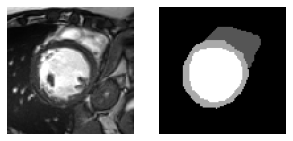

True

In [ ]:
import os
import cv2 #import OpenCV

data_dir = './data/train'
image = cv2.imread(os.path.join(data_dir,'image','cmr1.png'), cv2.IMREAD_UNCHANGED)
mask = cv2.imread(os.path.join(data_dir,'mask','cmr1_mask.png'), cv2.IMREAD_UNCHANGED)
show_image_mask(image, mask, cmap='gray')
plt.pause(1)
cv2.imwrite(os.path.join('./','cmr1.png'), mask*85)

Note: You will no doubt notice that the mask images appear to be completely black with no sign of any segmentations. This is because the max intensity of pixels in an 8-bit png image is 255 and your image viewer software only sees 255 as white. For those values close to zero, you will only see dark values. This is the case for our masks as the background, the right ventricle, the myocardium, and the left ventricle in each image are 0, 1, 2, and 3, respectively. All of which are close to zero. If we multiply the original mask by 85 and save the result to the directory where this code is, we can see the heart indeed shows up. 

## 2 Define a segmentation model with Pytorch

In this section, we expect you to learn how to:
* Define a Segmentation Model
* Define a DataLoader that inputs images to the Model
* Define training parameters and train the model
* Test the trained model with a new input image

### 2.1 Define a DataLoader

Below we provide you with a dataloader to use in your assigment. You will only need to focus on the development of your model and loss function.



In [ ]:
import torch
import torch.utils.data as data
import cv2
import os
from glob import glob

class TrainDataset(data.Dataset):
    def __init__(self, root=''):
        super(TrainDataset, self).__init__()
        self.img_files = glob(os.path.join(root,'image','*.png'))
        self.mask_files = []
        for img_path in self.img_files:
            basename = os.path.basename(img_path)
            self.mask_files.append(os.path.join(root,'mask',basename[:-4]+'_mask.png'))
            

    def __getitem__(self, index):
            img_path = self.img_files[index]
            mask_path = self.mask_files[index]
            data = cv2.imread(img_path, cv2.IMREAD_UNCHANGED)
            label = cv2.imread(mask_path, cv2.IMREAD_UNCHANGED)
            return torch.from_numpy(data).float(), torch.from_numpy(label).float()

    def __len__(self):
        return len(self.img_files)

class TestDataset(data.Dataset):
    def __init__(self, root=''):
        super(TestDataset, self).__init__()
        self.img_files = glob(os.path.join(root,'image','*.png'))

    def __getitem__(self, index):
            img_path = self.img_files[index]
            data = cv2.imread(img_path, cv2.IMREAD_UNCHANGED)
            return torch.from_numpy(data).float()

    def __len__(self):
        return len(self.img_files)


### 2.2 Define a Segmenatation Model

You will need to define your CNN model for segmentation below

In [ ]:
import torch
import torch.nn as nn
import torch.nn.functional as F


def double_conv(in_c, out_c, half=False):
    cut = in_c // 2 if half else out_c
    conv = nn.Sequential(
            nn.Conv2d(in_c, cut, kernel_size=3, padding=1),
            nn.BatchNorm2d(cut),
            nn.ReLU(inplace=True),
            nn.Conv2d(cut, out_c, kernel_size=3, padding=1),
            nn.BatchNorm2d(out_c),
            nn.ReLU(inplace=True))
    return conv


class UpConv(nn.Module):
    def __init__(self, in_c, out_c):
        super().__init__()
        self.up = nn.Upsample(scale_factor=2, mode='bilinear', align_corners=True)
        self.conv = double_conv(in_c, out_c, True)

    def forward(self, x1, x2):
        x1 = self.up(x1)

        delta_height = x2.size()[2] - x1.size()[2]
        delta_width = x2.size()[3] - x1.size()[3]

        x1 = F.pad(x1, [delta_width // 2, delta_width - delta_width // 2,
                        delta_height // 2, delta_height - delta_height // 2])

        x = torch.cat([x2, x1], dim=1)
        return self.conv(x)


def max_pool(in_c, out_c):
    maxpool = nn.Sequential(
            nn.MaxPool2d(2),
            double_conv(in_c, out_c))
    return maxpool


class CNNSEG(nn.Module):  # Define your model
    def __init__(self):
        super(CNNSEG, self).__init__()
        self.input_double_conv = double_conv(1, 64)
        self.down_conv_1 = max_pool(64, 128)
        self.down_conv_2 = max_pool(128, 256)
        self.down_conv_3 = max_pool(256, 512)
        self.down_conv_4 = max_pool(512, 512)
        self.up_conv_1 = UpConv(1024, 256)
        self.up_conv_2 = UpConv(512, 128)
        self.up_conv_3 = UpConv(256, 64)
        self.up_conv_4 = UpConv(128, 64)
        self.single_conv_out = nn.Conv2d(64, 4, kernel_size=1)

    def forward(self, x):
        x1 = self.input_double_conv(x)
        x2 = self.down_conv_1(x1)
        x3 = self.down_conv_2(x2)
        x4 = self.down_conv_3(x3)
        x5 = self.down_conv_4(x4)
        x = self.up_conv_1(x5, x4)
        x = self.up_conv_2(x, x3)
        x = self.up_conv_3(x, x2)
        x = self.up_conv_4(x, x1)
        return self.single_conv_out(x)


model = CNNSEG()

### 2.3 Define a Loss function and optimizer

You will need to define a loss function and an optimizer. torch.nn has a variety of readymade loss functions, although you may wish to create your own instead. torch.optim has a variety of optimizers, it is advised that you use one of these.

In [ ]:
Loss = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.001, betas=(0.9, 0.999), eps=1e-08, weight_decay=0, amsgrad=False)

### 2.4 Training

As most of you will use CPUs to train the model, expect your models to take **30 minutes to train if not longer depending on network architecture**. To save time, you should not be using all training data until your model is well developed. If you are running your model on a GPU training should be significantly faster. During the training process, you may want to save the checkpoints as follows:

```
# Saving checkpoints for validation/testing
torch.save(model.state_dict(), path)
```
The saved checkpoints can be used to load at a later date for validation and testing. Here we give some example code for training a model. Note that you need to specify the max iterations you want to train the model.

In [ ]:
from torch.utils.data import DataLoader

data_path = './data/train'
num_workers = 4
batch_size = 4
train_set = TrainDataset(data_path)
training_data_loader = DataLoader(dataset=train_set, num_workers=num_workers, batch_size=batch_size, shuffle=True)
min_loss = float('inf')
saved_model_path = 'model.sav'
model.train()
# Fetch images and labels.  
for epoch in range(epochs):
        for iteration, sample in enumerate(training_data_loader):
            image, mask = sample
            print("Epochs " + str(epoch + 1), "Iteration " + str(iteration + 1))


            optimizer.zero_grad()
            image = image.unsqueeze(1)

            pred = model(image)

            loss = Loss(pred, mask.long())
            # show_image_mask(image[0, ...].squeeze(), torch.argmax(pred, dim=1)[0, ...])
            # plt.pause(1)
            print('Loss: ', loss.item(), " minimum: ", min_loss)

            if loss.item() < min_loss:
                min_loss = loss.item()
                torch.save(model.state_dict(), saved_model_path)

        
            loss.backward()
            optimizer.step()
            ckpt_path = ''
            path = os.path.join(ckpt_path, 'net_{}.pth'.format(iteration))
    
            torch.save(model.state_dict(), path)

Epochs 1 Iteration 1
Loss:  0.04400264099240303  minimum:  inf
Epochs 1 Iteration 2
Loss:  0.04816789925098419  minimum:  0.04400264099240303
Epochs 1 Iteration 3
Loss:  0.03885683789849281  minimum:  0.04400264099240303
Epochs 1 Iteration 4
Loss:  0.03288867697119713  minimum:  0.03885683789849281
Epochs 1 Iteration 5
Loss:  0.05597619712352753  minimum:  0.03288867697119713
Epochs 1 Iteration 6
Loss:  0.03754091635346413  minimum:  0.03288867697119713
Epochs 1 Iteration 7
Loss:  0.0537618063390255  minimum:  0.03288867697119713
Epochs 1 Iteration 8
Loss:  0.0471360944211483  minimum:  0.03288867697119713
Epochs 1 Iteration 9
Loss:  0.03495115414261818  minimum:  0.03288867697119713
Epochs 1 Iteration 10
Loss:  0.03521004319190979  minimum:  0.03288867697119713
Epochs 1 Iteration 11
Loss:  0.031321629881858826  minimum:  0.03288867697119713
Epochs 1 Iteration 12
Loss:  0.044750139117240906  minimum:  0.031321629881858826
Epochs 1 Iteration 13
Loss:  0.0427495576441288  minimum:  0.031

### 2.5 Testing

When validating the trained checkpoints (models), remember to change the model status as **Evaluation Mode**

In [ ]:
import numpy as np
from torch.autograd import Variable

In [ ]:
# In this block you are expected to write code to load saved model and deploy it to all data in test set to 
# produce segmentation masks in png images valued 0,1,2,3, which will be used for the submission to Kaggle.
data_path = './data/test'
num_workers = 4
batch_size = 4

test_set = TestDataset(data_path)
test_data_loader = DataLoader(dataset=test_set, num_workers=num_workers,batch_size=batch_size, shuffle=False)

model.eval()


for iteration, sample in enumerate(test_data_loader):
    img = sample
    #print(img.shape)
    #show_image_mask(img[0,...].squeeze(), mask[0,...].squeeze()) #visualise all data in training set
    
    
    #plt.pause(1)
    #plt.imshow(img[0,...].squeeze(), cmap='gray') #visualise all images in test set
    #plt.pause(1)
    img= img.unsqueeze(1)

    pred = model(img)
    print(pred.shape)
    print(img.shape)
    #pred = torch.sigmoid(pred)
    pred = torch.argmax(pred.squeeze(),dim=1)
    #plt.imshow(pred[0,...].squeeze())
    #plt.pause(1)
    print(pred.shape)
    show_image_mask(img[0,...].squeeze().cpu(), pred[0,...].cpu())
    show_image_mask(img[0,...].squeeze().cpu(), pred[1,...].cpu())
    show_image_mask(img[0,...].squeeze().cpu(), pred[2,...].cpu())
    show_image_mask(img[0,...].squeeze().cpu(), pred[3,...].cpu())
    plt.pause(1)
    
    
    
    
    
    #print(pred.shape)
    #im = transforms.ToPILImage()(pred[1])
    if torch.cuda.is_available():
      pred = pred.detach().cpu().numpy()
      img1 = img.detach().cpu().numpy()
    #print(pred)
    #img2 = Image.fromarray(pred, mode="RGBa")
    
    
    

    
    #plt.imsave( "./data/test/mask/cmr{}.png".format(iteration), pred[1,...].squeeze(), cmap="gray") 

## 3 Evaluation

As we will automatically evaluate your predicted test makes on Kaggle, in this section we expect you to learn:
* what is the Dice score used on Kaggle to measure your models performance
* how to submit your predicted masks to Kaggle

### 3.1 Dice Score

To evaluate the quality of the predicted masks, the Dice score is adopted. Dice score on two masks A and B is defined as the intersection ratio between the overlap area and the average area of two masks. A higher Dice suggests a better registration.

$Dice (A, B)= \frac{2|A \cap B|}{|A| + |B|} $

However, in our coursework, we have three labels in each mask, we will compute the Dice score for each label and then average the three of them as the final score. Below we have given you `categorical_dice` for free so you can test your results before submission to Kaggle.

In [ ]:
def categorical_dice(mask1, mask2, label_class=1):
    """
    Dice score of a specified class between two volumes of label masks.
    (classes are encoded but by label class number not one-hot )
    Note: stacks of 2D slices are considered volumes.

    Args:
        mask1: N label masks, numpy array shaped (H, W, N)
        mask2: N label masks, numpy array shaped (H, W, N)
        label_class: the class over which to calculate dice scores

    Returns:
        volume_dice
    """
    mask1_pos = (mask1 == label_class).astype(np.float32)
    mask2_pos = (mask2 == label_class).astype(np.float32)
    dice = 2 * np.sum(mask1_pos * mask2_pos) / (np.sum(mask1_pos) + np.sum(mask2_pos))
    return dice

torch.Size([4, 4, 96, 96])
torch.Size([4, 1, 96, 96])


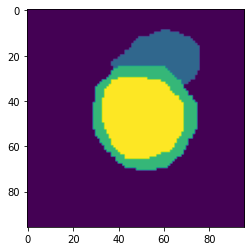

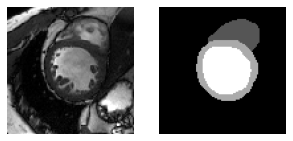

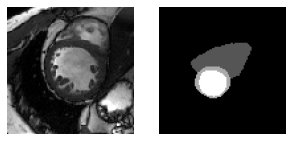

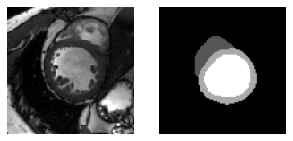

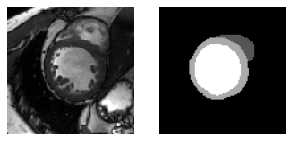

0.9686450167973124
0.9316062176165804
0.9848394768133175
0.9616969037424035
torch.Size([4, 4, 96, 96])
torch.Size([4, 1, 96, 96])


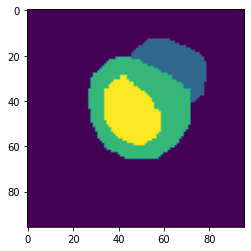

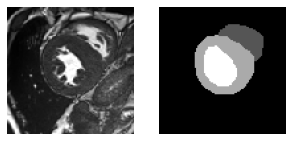

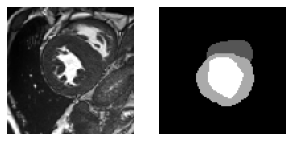

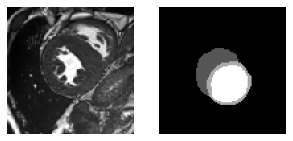

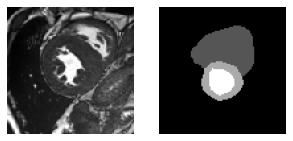

0.9711147274206672
0.9530995106035889
0.973384030418251
0.9658660894808356
torch.Size([4, 4, 96, 96])
torch.Size([4, 1, 96, 96])


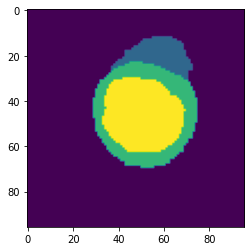

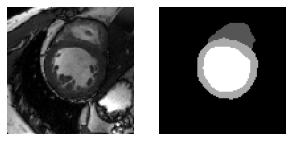

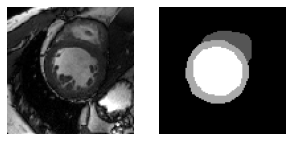

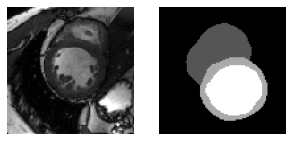

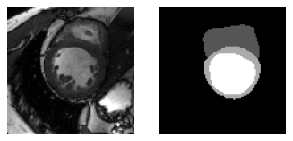

0.9694555112881806
0.927694406548431
0.9796606089782164
0.9589368422716094
torch.Size([4, 4, 96, 96])
torch.Size([4, 1, 96, 96])


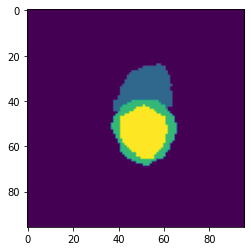

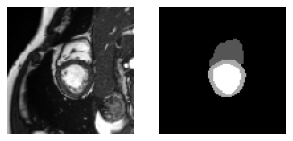

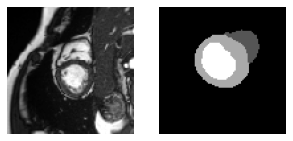

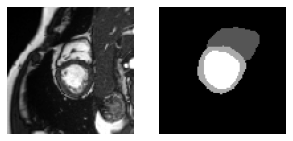

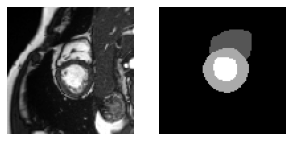

0.9713610865072335
0.9492273730684326
0.9778401122019635
0.9661428572592099
torch.Size([4, 4, 96, 96])
torch.Size([4, 1, 96, 96])


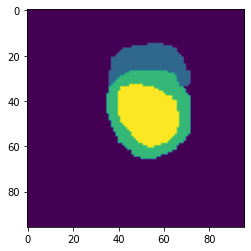

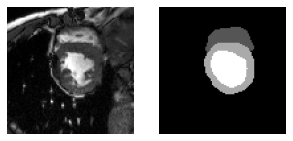

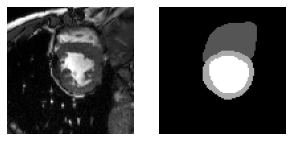

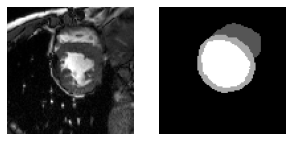

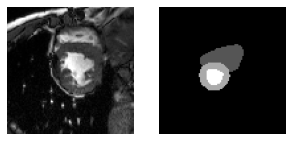

0.972318339100346
0.9366041896361632
0.9813534464697256
0.9634253250687449
torch.Size([4, 4, 96, 96])
torch.Size([4, 1, 96, 96])


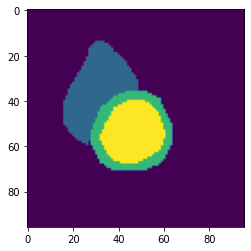

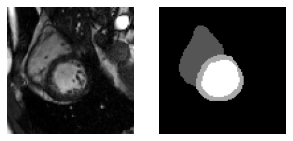

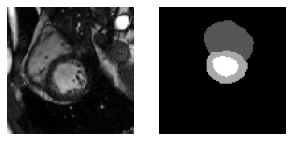

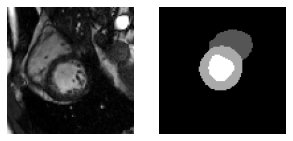

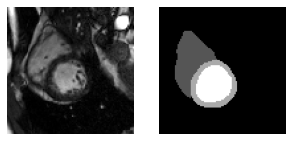

0.9722171781369167
0.9431687715269805
0.9791183294663574
0.9648347597100848
torch.Size([4, 4, 96, 96])
torch.Size([4, 1, 96, 96])


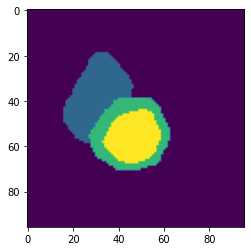

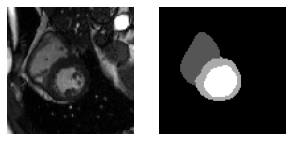

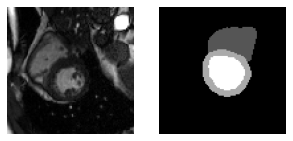

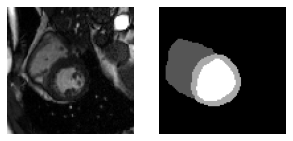

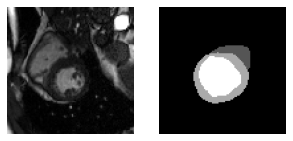

0.9762445775666184
0.9375328083989501
0.9777503090234858
0.9638425649963515
torch.Size([4, 4, 96, 96])
torch.Size([4, 1, 96, 96])


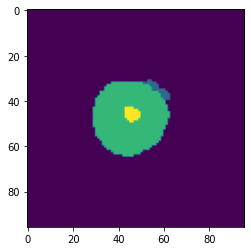

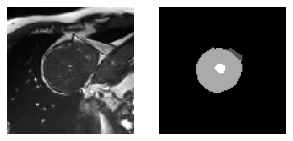

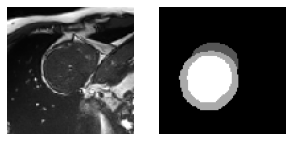

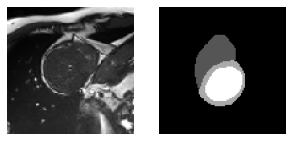

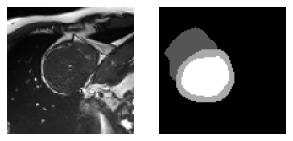

0.9633473889069089
0.948017259091843
0.9820534223706177
0.9644726901231232
torch.Size([4, 4, 96, 96])
torch.Size([4, 1, 96, 96])


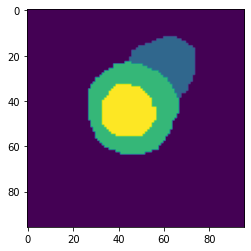

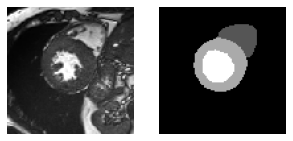

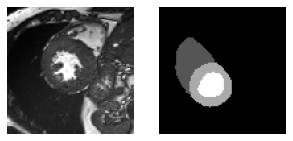

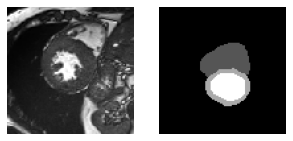

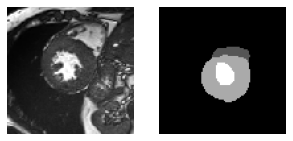

0.9689213893967094
0.9593625498007968
0.9685580050596314
0.9656139814190459
torch.Size([4, 4, 96, 96])
torch.Size([4, 1, 96, 96])


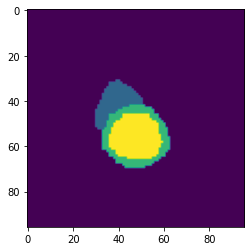

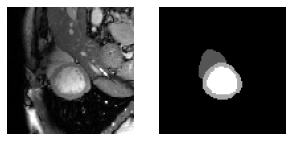

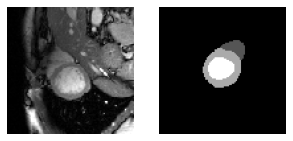

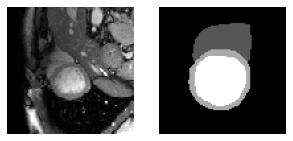

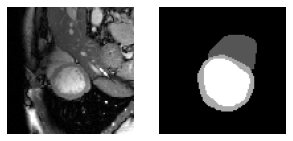

0.9712737127371274
0.9182010262601872
0.976653003029763
0.9553759140090259
torch.Size([4, 4, 96, 96])
torch.Size([4, 1, 96, 96])


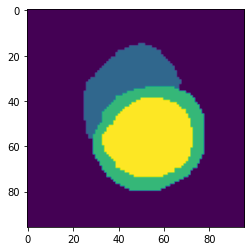

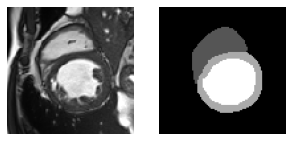

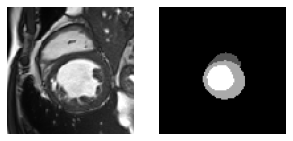

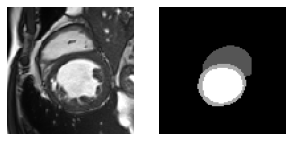

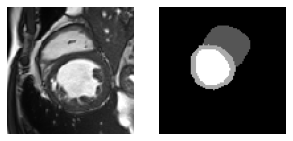

0.973816717019134
0.9367720465890182
0.9789534659200618
0.9631807431760713
torch.Size([4, 4, 96, 96])
torch.Size([4, 1, 96, 96])


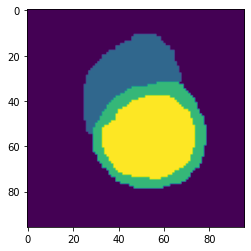

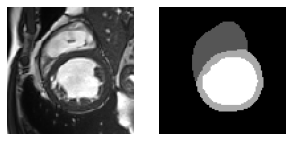

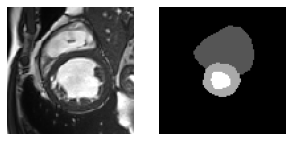

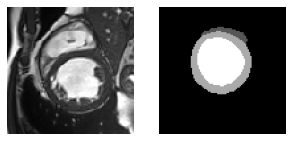

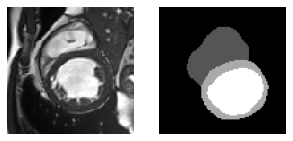

0.9748759305210918
0.9409875551987154
0.9818287541793865
0.9658974132997312
torch.Size([4, 4, 96, 96])
torch.Size([4, 1, 96, 96])


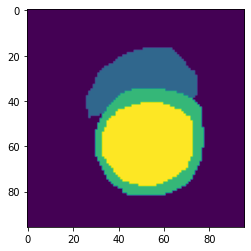

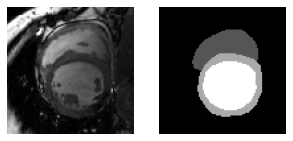

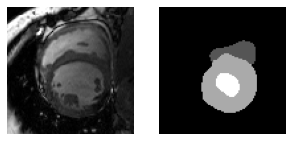

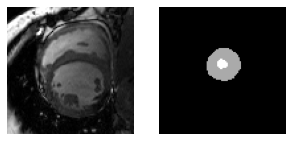

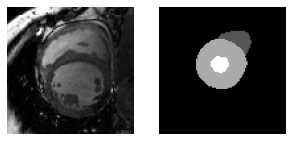

0.9588256355173649
0.960589651022864
0.9773923815422731
0.9656025560275007
torch.Size([4, 4, 96, 96])
torch.Size([4, 1, 96, 96])


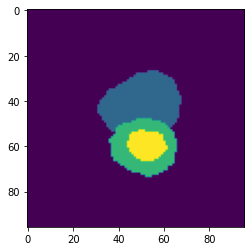

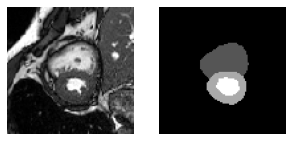

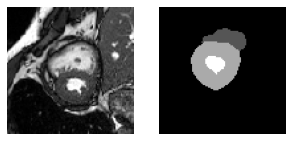

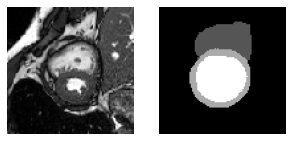

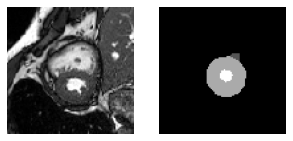

0.97285675893577
0.9584727415863019
0.9698407319552694
0.9670567441591138
torch.Size([4, 4, 96, 96])
torch.Size([4, 1, 96, 96])


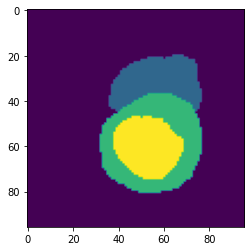

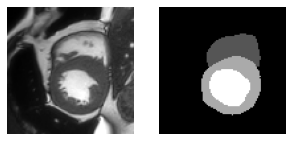

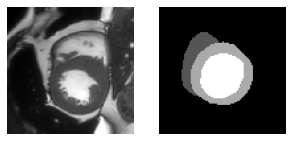

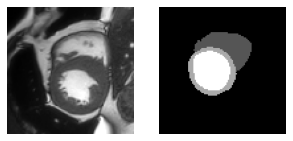

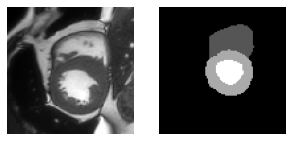

0.9683410721823554
0.9550919377652051
0.9781050955414012
0.9671793684963207
torch.Size([4, 4, 96, 96])
torch.Size([4, 1, 96, 96])


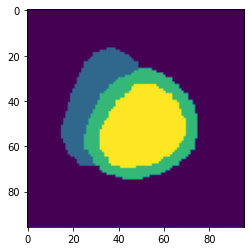

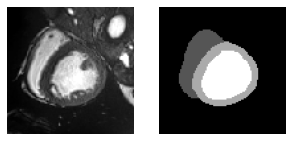

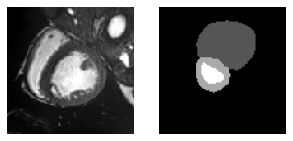

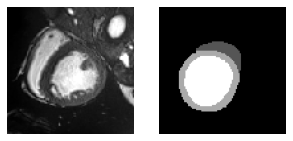

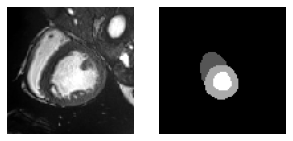

0.9655028224963412
0.9422987436016752
0.9820846905537459
0.9632954188839209
torch.Size([4, 4, 96, 96])
torch.Size([4, 1, 96, 96])


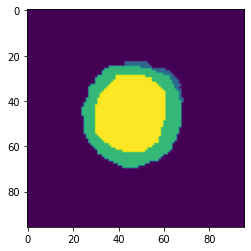

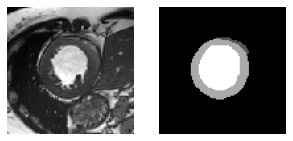

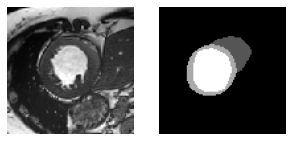

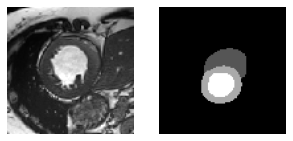

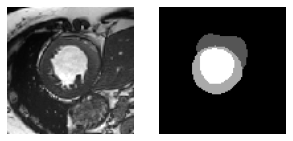

0.936658749010293
0.9408521303258145
0.981666002391391
0.953058960575833
torch.Size([4, 4, 96, 96])
torch.Size([4, 1, 96, 96])


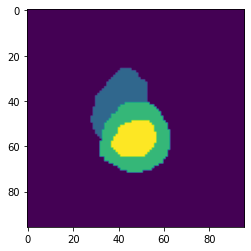

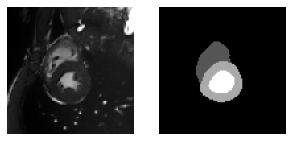

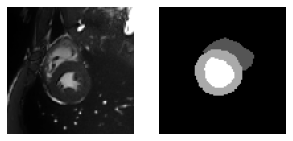

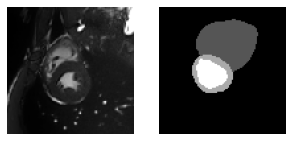

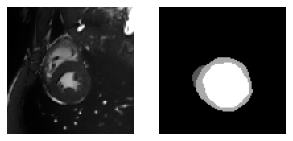

0.9641453831041258
0.9357556608741443
0.9701610773699498
0.95668737378274
torch.Size([4, 4, 96, 96])
torch.Size([4, 1, 96, 96])


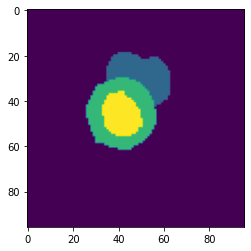

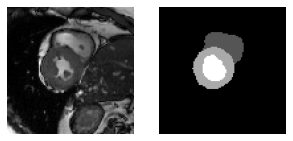

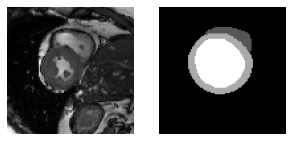

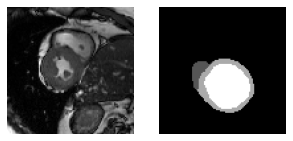

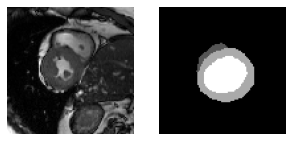

0.9417693169092946
0.9450741063644289
0.980594195431908
0.9558125395685438
torch.Size([4, 4, 96, 96])
torch.Size([4, 1, 96, 96])


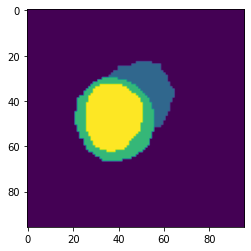

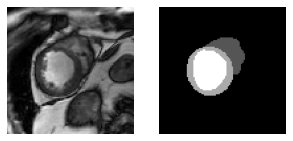

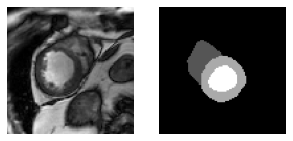

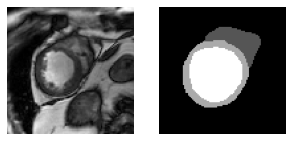

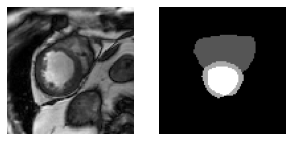

0.965851509142983
0.9447184012457825
0.9838588588588588
0.964809589749208
torch.Size([4, 4, 96, 96])
torch.Size([4, 1, 96, 96])


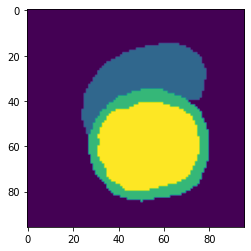

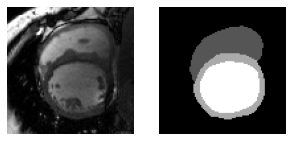

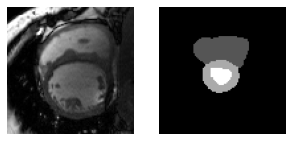

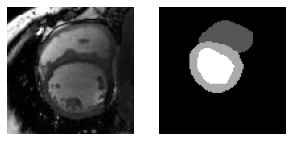

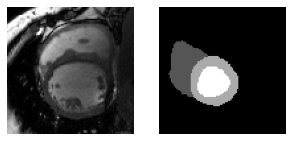

0.9678357847098755
0.9440967876512307
0.9747997655792147
0.9622441126467737
torch.Size([4, 4, 96, 96])
torch.Size([4, 1, 96, 96])


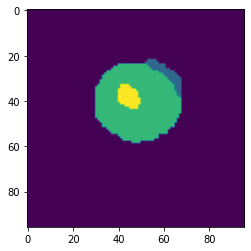

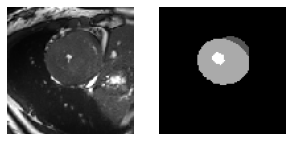

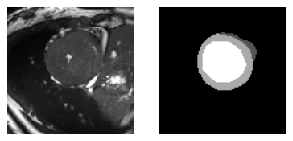

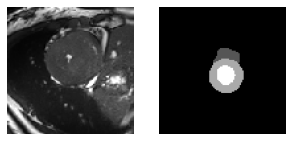

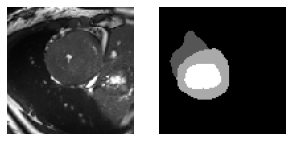

0.9276595744680851
0.9627855563743551
0.9755607633076665
0.9553352980500356
torch.Size([4, 4, 96, 96])
torch.Size([4, 1, 96, 96])


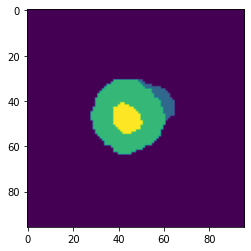

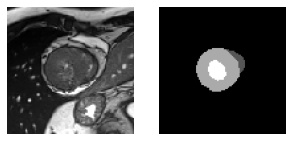

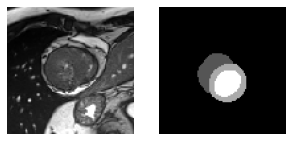

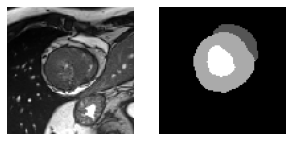

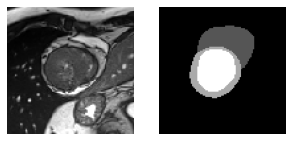

0.9584335279972518
0.9622993654348637
0.972027972027972
0.9642536218200292
torch.Size([4, 4, 96, 96])
torch.Size([4, 1, 96, 96])


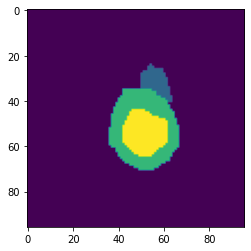

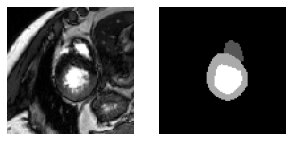

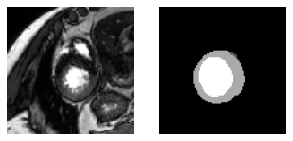

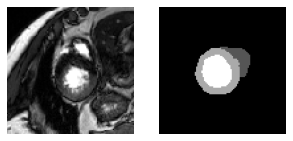

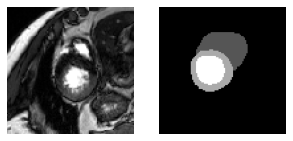

0.9516046867040244
0.9376985096506231
0.969437303627535
0.9529134999940609
torch.Size([4, 4, 96, 96])
torch.Size([4, 1, 96, 96])


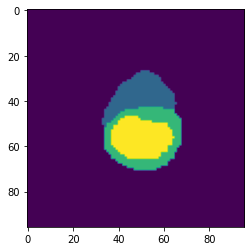

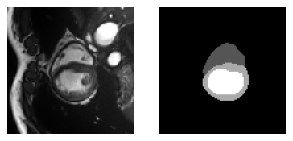

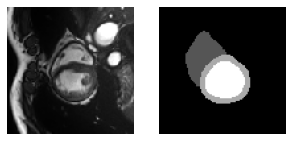

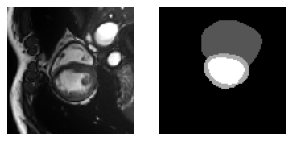

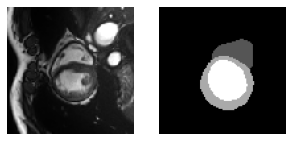

0.9776074238450676
0.9301204819277108
0.9792325056433409
0.9623201371387063


In [ ]:
#evalute
data_path = './data/val'
num_workers = 4
batch_size = 4



#val_set = TestDataset(data_path)
#val_data_loader = DataLoader(dataset=val_set, num_workers=num_workers,batch_size=batch_size, shuffle=False)





val_set = TrainDataset(data_path)
val_data_loader = DataLoader(dataset=train_set, num_workers=num_workers, batch_size=batch_size, shuffle=False)
model.eval()
# Fetch images and labels.  







for iteration, sample in enumerate(val_data_loader):
    img,mask = sample
    #print(img.shape)
    #show_image_mask(img[0,...].squeeze(), mask[0,...].squeeze()) #visualise all data in training set
    #i += 1
        
        
        
    #data_dir = './data/val/mask/'
    #print(iteration)
    #if(i < 10):
    #    print('cmr10{}_mask.png'.format(i))
    #    mask = cv2.imread(os.path.join(data_dir,'cmr10{}_mask.png'.format(i)), cv2.IMREAD_UNCHANGED)
    #    plt.imshow(mask)
    #else:
    #    print('cmr1{}_mask.png'.format(i))
    #    mask = cv2.imread(os.path.join(data_dir,'mask','cmr1{}_mask.png'.format(i)), cv2.IMREAD_UNCHANGED)
    #    plt.imshow(mask)
    
    #plt.pause(1)
    #plt.imshow(img[0,...].squeeze(), cmap='gray') #visualise all images in test set
    #plt.pause(1)
    img= img.unsqueeze(1)

    pred = model(img)
    print(pred.shape)
    print(img.shape)
    #pred = torch.sigmoid(pred)
    #pred = torch.sigmoid(pred)
    pred = torch.argmax(pred.squeeze(),dim=1)
    #plt.imshow(pred[0,...].squeeze())
    #plt.pause(1)

    

    mask = mask.cpu().numpy()
    plt.imshow(mask[0,...].squeeze())
    plt.pause(1)
    
    #print(pred.shape)
    #im = transforms.ToPILImage()(pred[1])
    if torch.cuda.is_available():
        pred = pred.detach().cpu().numpy()
        img = img.detach().cpu().numpy()
    else:
        pred = pred.cpu().numpy()
        img = img.cpu().numpy()


        
        
        
    show_image_mask(img[0,...].squeeze(), pred[0,...])
    plt.pause(1)
    show_image_mask(img[0,...].squeeze(), pred[1,...])
    plt.pause(1)
 
    
    show_image_mask(img[0,...].squeeze(), pred[2,...])

    plt.pause(1)
    show_image_mask(img[0,...].squeeze(), pred[3,...])
   
    plt.pause(1)
    
    
    print(categorical_dice(mask,pred,label_class = 1))
    print(categorical_dice(mask,pred,label_class = 2))
    print(categorical_dice(mask,pred,label_class = 3))
    print((categorical_dice(mask,pred,label_class = 1)+categorical_dice(mask,pred,label_class = 2)+categorical_dice(mask,pred,label_class = 3))/3)
    
    





### 3.2 Submission

Kaggle requires your submission to be in a specific CSV format. To help ensure your submissions are in the correct format, we have provided some helper functions to do this for you. For those interested, the png images are run-length encoded and saved in a CSV to the specifications required by our competition.

It is sufficient to use this helper function. To do so, save your 80 predicted masks into a directory. ONLY the 80 predicted masks should be in this directory. Call the submission_converter function with the first argument as the directory containing your masks, and the second the directory in which you wish to save your submission.

In [ ]:
import numpy as np
import os
import cv2

def rle_encoding(x):
    '''
    *** Credit to https://www.kaggle.com/rakhlin/fast-run-length-encoding-python ***
    x: numpy array of shape (height, width), 1 - mask, 0 - background
    Returns run length as list
    '''
    dots = np.where(x.T.flatten() == 1)[0]
    run_lengths = []
    prev = -2
    for b in dots:
        if (b > prev + 1): run_lengths.extend((b + 1, 0))
        run_lengths[-1] += 1
        prev = b
    return run_lengths


def submission_converter(mask_directory, path_to_save):
    writer = open(os.path.join(path_to_save, "submission.csv"), 'w')
    writer.write('id,encoding\n')

    files = os.listdir(mask_directory)

    for file in files:
        name = file[:-4]
        mask = cv2.imread(os.path.join(mask_directory, file), cv2.IMREAD_UNCHANGED)

        mask1 = (mask == 1)
        mask2 = (mask == 2)
        mask3 = (mask == 3)

        encoded_mask1 = rle_encoding(mask1)
        encoded_mask1 = ' '.join(str(e) for e in encoded_mask1)
        encoded_mask2 = rle_encoding(mask2)
        encoded_mask2 = ' '.join(str(e) for e in encoded_mask2)
        encoded_mask3 = rle_encoding(mask3)
        encoded_mask3 = ' '.join(str(e) for e in encoded_mask3)

        writer.write(name + '1,' + encoded_mask1 + "\n")
        writer.write(name + '2,' + encoded_mask2 + "\n")
        writer.write(name + '3,' + encoded_mask3 + "\n")

    writer.close()